In [446]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder, CatBoostEncoder, JamesSteinEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
%config Completer.use_jedi = False

This is a template for your final project. 

In [2]:
full_dataset = pd.read_csv('IMDb movies.csv')
full_dataset.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0


### Part 1.

Task formalization and Evaluation criteria

1.1 Select your target variable, explain your choice. Separate target variable from the feature matrix.

Let's looks at the percentages of missing values per feature first.

In [3]:
(full_dataset.isna().sum() / full_dataset.shape[0] * 100).apply(lambda x: round(x, 2)).astype(str) + '%'

imdb_title_id              0.0%
title                      0.0%
original_title             0.0%
year                       0.0%
date_published             0.0%
genre                      0.0%
duration                   0.0%
country                   0.01%
language                  0.73%
director                  0.04%
writer                    1.34%
production_company        4.56%
actors                    0.05%
description               3.31%
avg_vote                   0.0%
votes                      0.0%
budget                   72.06%
usa_gross_income         80.25%
worlwide_gross_income    68.21%
metascore                85.36%
reviews_from_users        6.76%
reviews_from_critics     13.67%
dtype: object

As we can see, we have 4 features with > 68% missing values. 3 of them could potentially be interrsting in estimating movie's success, but due to their scarceness we will avoid them.

The remaning features that could be used as target are **avg_vote, votes, reviews_from_users, reviews_from_critics**. Let's analyze the last two.  

In [4]:
full_dataset[['reviews_from_users', 'reviews_from_critics']].describe()

,reviews_from_users,reviews_from_critics
count,56129.000000,51969.000000
mean,44.926901,27.269872
std,152.973352,55.689940
min,1.000000,1.000000
25%,4.000000,3.000000
50%,10.000000,8.000000
75%,28.000000,24.000000
max,7029.000000,837.000000


It seems these features are descrete and represents the number of reviews from critics and users separately. By it's own they cannot represent movie's success because we need an actual score, not only the number of scores. Most probably these two features come from Metacritic, as well as already ignored by us **metascore** feature. 

We also have **votes** and **avg_vote** features that probably is a rating of a movie at imdb itself due to the fact that there no missing values for those two. Let's sanity check that **votes** represent number of votes not equal to the sum of two other features with critic and user votes

In [5]:
full_dataset['votes'] - (full_dataset['reviews_from_critics'] + full_dataset['reviews_from_users'])

0          523.0
1          165.0
2          393.0
3         1977.0
4          421.0
          ...   
60193       99.0
60194     7558.0
60195       97.0
60196      340.0
60197    13112.0
Length: 60198, dtype: float64

This series doesn't consist of zeros so our assumption is true.

So, we are left with two possbile options - **votes** and **avg_votes**. We wiil try to use both of them, because it our measure should not only indicate the score of movie but also the quality of this score. The more scores the movie has, the more trustworthy it's average score is. Let's look at the distrubtion of average scores:

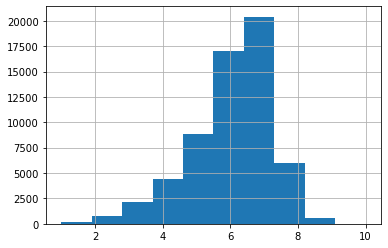

In [6]:
full_dataset['avg_vote'].hist();

It is approximately normal on scale from 0 to 10. We need to maintain this scale while incorporating the number of reviews into our score. We will use next formula:
$$score=P\cdot p+10\cdot (1-P)\cdot (1-e^{-q/Q})$$

Here P - is skewness coefficient. We will leave it at $\frac{1}{2}$ to maintain scale.
*p* - average score, *q* - number of scores, *Q* - quantity "importance" measure.
We will compute *Q* as
$$Q=\frac{−M}{ln{\frac{1}{2}}}$$ where M - is number of reviews that we consider as "moderate". We will pick median value of the number of reviews as M.

In [7]:
def extract_target(df):
    q = -df['votes'].median() / np.log(0.5)
    score = 0.5 * df['avg_vote'] + 5 * (1 - np.exp(-df['votes'] / q))
    return df.drop(['avg_vote', 'votes'], axis=1), score

In [8]:
X, y = extract_target(full_dataset)

Now let's find two movies with high score but small and high number of reviews to make sure that our formula worked as intended.

In [9]:
full_dataset[full_dataset['avg_vote'] == 9.5][['avg_vote', 'votes']]

,avg_vote,votes
51931,9.5,1017
51977,9.5,617


In [10]:
y[[51931, 51977]]

51931    8.518805
51977    7.613443
dtype: float64

We see that, despite that both movies got 9.5 as their average score, the one with higher amount of votes recieved higher score with our method.

1.2 Explain which task are you going to solve (is it a regression, classification or something else)? 

This is clearly a regression task. Our model will predict the score of the movie, which reflects not only the level of acceptance, but also the estimate popularity.

1.3 Select a metric. Is it already implemented in sklearn? If yes, import it. If not, it is time to write a function which will calculate it. 

In [11]:
X.describe()

,year,duration,metascore,reviews_from_users,reviews_from_critics
count,60198.000000,60198.000000,8812.000000,56129.000000,51969.000000
mean,1985.308366,99.744825,55.532229,44.926901,27.269872
std,23.308107,22.753228,17.885123,152.973352,55.689940
min,1906.000000,40.000000,1.000000,1.000000,1.000000
25%,1970.000000,88.000000,43.000000,4.000000,3.000000
50%,1992.000000,95.000000,56.000000,10.000000,8.000000
75%,2005.000000,107.000000,68.000000,28.000000,24.000000
max,2019.000000,729.000000,100.000000,7029.000000,837.000000


In [12]:
X.describe(include='O')

,imdb_title_id,title,original_title,date_published,genre,country,language,director,writer,production_company,actors,description,budget,usa_gross_income,worlwide_gross_income
count,60198,60198,60198,60198,60198,60193,59759,60174,59390,57454,60168,58205,16819,11892,19136
unique,60198,57284,57290,19431,1202,3318,3192,22771,47546,21441,60145,58126,3503,11529,18920
top,tt0259060,The Three Musketeers,The Three Musketeers,2010,Drama,USA,English,Michael Curtiz,Jing Wong,Metro-Goldwyn-Mayer (MGM),"Nobuyo Ôyama, Noriko Ohara, Michiko Nomura, Ka...",Mail,$ 1000000,$ 1000000,$ 8144
freq,1,8,8,101,8498,22080,27008,86,70,1277,13,7,512,19,16


The variance of numerical features as well as cardinality of categorical is quite large, so we will use $R^2$ metric as a measure of abilty of our model to explain the variance of it's features.

In [257]:
from sklearn.metrics import r2_score

### Part 2.

Explore and preprocess the data

2.1 Split data into train and test

In [14]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

2.2 Explore you data: make plots, print tables. Make sure to write your observations.  Do not forget to fill-in missing values, define relevant columns transformatios. 


For plotting we will create a separate dataframe

In [15]:
df_plot = full_dataset.copy()
df_plot['score'] = extract_target(df_plot)[1]
df_plot.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,score
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0,5.664431
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0,3.999685
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0,4.797065
3,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,Loosely adapted from Dante's Divine Comedy and...,7.0,2019,NaN,NaN,NaN,NaN,28.0,14.0,8.190500
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,...,"An account of the life of Jesus Christ, based ...",5.7,438,NaN,NaN,NaN,NaN,12.0,5.0,5.115736


## Categorical

- imdb_title_id   *(drop)*
- title   *(drop)*
- original_title   *(drop)*
- year   *(CatBoostEncoder, MinMaxScaler)*
- date_published   *(extract month, day of week, OHE)*
- genre *(CountVectorizer)*
- country *(CountVectorizer)*
- language *(GroupbyImputer, CatBoostEncoder, MinMaxScaler)*
- director *(CatBoostEncoder, MinMaxScaler)*
- writer *(drop)*
- production_company *(CatBoostEncoder, MinMaxScaler)*
- actors *(drop)*
- description *(drop)*

In [16]:
cat_cols = list(X_tr.select_dtypes('O').drop(['budget', 'usa_gross_income', 'worlwide_gross_income'], axis=1).columns) + ['year']
X_tr[cat_cols].describe(include='all')

,imdb_title_id,title,original_title,date_published,genre,country,language,director,writer,production_company,actors,description,year
count,45148,45148,45148,45148,45148,45144,44813,45132,44548,43104,45125,43647,45148.000000
unique,45148,43412,43417,16989,1099,2677,2545,19102,36868,17527,45111,43607,NaN
top,tt0079191,The Three Musketeers,The Three Musketeers,2008,Drama,USA,English,Jesús Franco,Jing Wong,Metro-Goldwyn-Mayer (MGM),"Nobuyo Ôyama, Noriko Ohara, Michiko Nomura, Ka...",Mail,NaN
freq,1,7,7,75,6262,16681,20410,65,60,968,10,6,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985.213542
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.331377
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1906.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1992.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005.000000


### Imdb_title_id, title, original_title

In [17]:
round(full_dataset[['imdb_title_id', 'title', 'original_title']].nunique() /full_dataset.shape[0] * 100, 2)\
.astype(str) + '%'

imdb_title_id     100.0%
title             95.16%
original_title    95.17%
dtype: object

These 3 features have very high cardinality, with almost 100% unique values. Also,they don't carry any meaningfull information so we can sefely drop them.

### Year, date_published

In [18]:
print(f"Missing values: \n{full_dataset[['year', 'date_published']].isna().sum()}")

Missing values: 
year              0
date_published    0
dtype: int64


Let's look how the average score changes with passing years

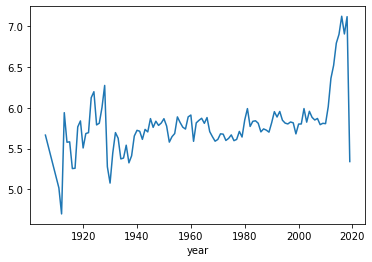

In [19]:
df_plot.groupby('year')['score'].mean().plot();

Seems reasonable to use this feature in our model, but first we will need to impute it (SimpleImputer will do in this case) and encode it apporpiately (OHE).

Next we will analyze how month or type of day when the film was released affect score

In [20]:
df_plot['date_published'] = pd.to_datetime(df_plot['date_published'])
df_plot['month'] = df_plot['date_published'].dt.month
df_plot['day_of_week'] = df_plot['date_published'].dt.dayofweek

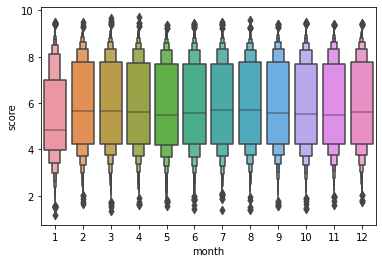

In [21]:
sns.boxenplot(data=df_plot, x='month', y='score');

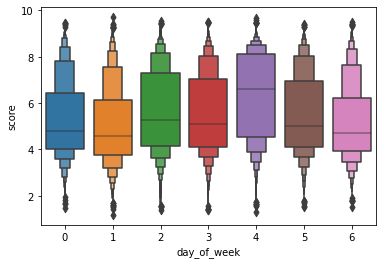

In [22]:
sns.boxenplot(data=df_plot, x='day_of_week', y='score');

Both features can be used here. Month distribution seems uniform however there is a strange fluctuatuion in January, this could possibly mean something. Because these two features are not actually numerical, but rather categorical we will encode them with OHE

### Genre

In [23]:
print(f"Missing values: {full_dataset['genre'].isna().sum()}")

Missing values: 0


We will use CountVectorizer for tokenization and encoding of all possbile genres. We will include custom pattern to iinclude genres with hyphen in them as one genre instead of two.

In [24]:
cv = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b')
genres = cv.fit_transform(df_plot['genre'])
cv.get_feature_names()

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'reality-tv',
 'romance',
 'sci-fi',
 'sport',
 'thriller',
 'war',
 'western']

In [25]:
genres_df = pd.DataFrame(genres.toarray(), columns=cv.get_feature_names())
genres_df['score'] = df_plot['score']
genres_df.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,musical,mystery,reality-tv,romance,sci-fi,sport,thriller,war,western,score
0,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,5.664431
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3.999685
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4.797065
3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,8.190500
4,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5.115736


In [26]:
cv.get_feature_names()

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'reality-tv',
 'romance',
 'sci-fi',
 'sport',
 'thriller',
 'war',
 'western']

In [27]:
plot_genres = pd.melt(genres_df, var_name='genres', id_vars='score')
plot_genres = plot_genres[plot_genres['value'] == 1]

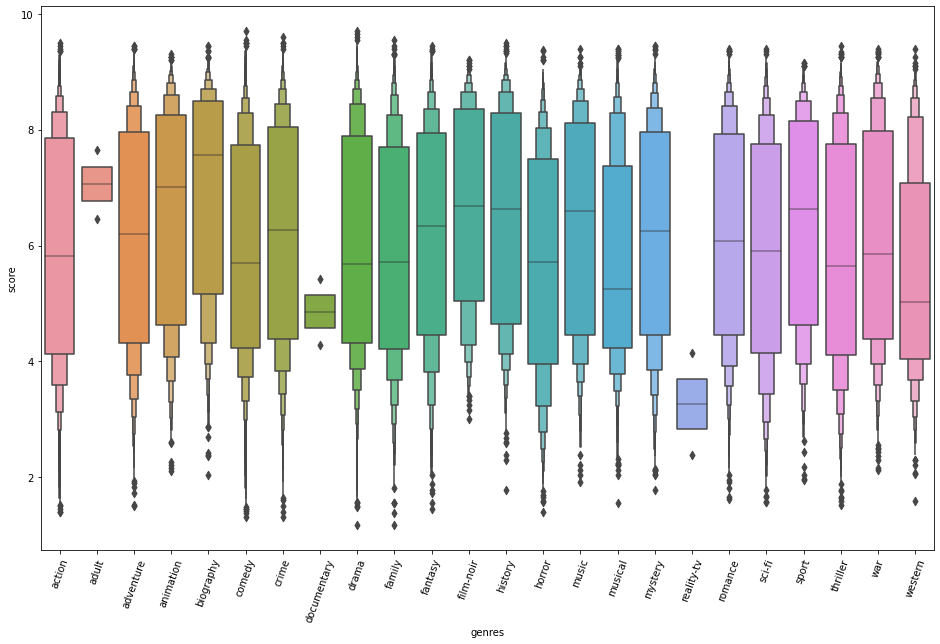

In [28]:
plt.figure(figsize=(16, 10))
sns.boxenplot(data=plot_genres, x='genres', y='score')
plt.xticks(rotation=70);

We will use this feature.

### Country, language

In [29]:
print(f"Missing values: \n{full_dataset[['country','language']].isna().sum()}")

Missing values: 
country       5
language    439
dtype: int64


For country we will use CatBoost Encoder, which will handle missing values for us.

We will look at our score distribution based on top 10 most frequent countries first

In [30]:
cty = df_plot['country'].value_counts().iloc[:10]
cty

USA          22080
India         3041
UK            2992
France        2330
Japan         2132
Italy         1871
Canada        1139
Hong Kong     1090
Germany        903
Spain          844
Name: country, dtype: int64

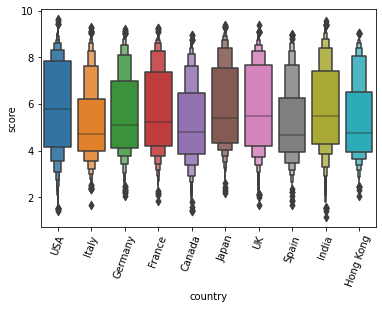

In [31]:
sns.boxenplot(data=df_plot[df_plot.country.isin(cty.index)], x='country', y='score')
plt.xticks(rotation=70);

Now let's analyze language of the movies. Again we will take top 10 languages

In [32]:
lang = df_plot['language'].value_counts().iloc[:10]
lang

English             27008
French               2972
Italian              2202
Japanese             1915
Spanish              1837
German               1340
Hindi                1340
Russian               934
English, Spanish      849
Turkish               731
Name: language, dtype: int64

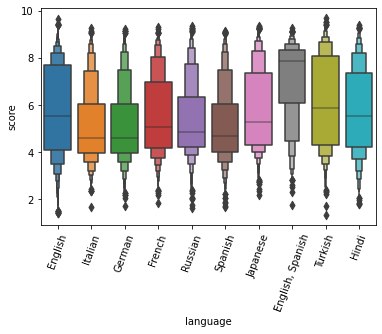

In [33]:
sns.boxenplot(data=df_plot[df_plot.language.isin(lang.index)], x='language', y='score')
plt.xticks(rotation=70);

In [34]:
df_plot.language.isna().sum(), df_plot.language.nunique()

(439, 3192)

We see pretty high variance here and this is good for the feature. We will use it. But it has considerable amount of missing values. It will not be correct to use most frequent SimpleImputer here becuse language depends on the country where the movie was casted. So we will use custom imputer here and then we will CatBoost Encode this feature, due to it's high cardinality

In [279]:
class GroupbyImputer(TransformerMixin, BaseEstimator):

    
    def __init__(self, groupby_column, train_value=None):
        self.groupby_column = groupby_column
        self.train_value = train_value


    def fit(self, X, y=None):
        self.res = X.drop(self.groupby_column, axis=1).iloc[:, 0]
        self.train_value = (
            X.dropna(subset=['language'])
            .groupby(self.groupby_column)
            .agg(lambda X: X.value_counts().index[0])
        )
        
        # calculate overall mode of null_column
        self.overall = self.res.mode()[0]

        return self

    def transform(self, X):
        self.res = X.drop(self.groupby_column, axis=1).iloc[:, 0]
#         impute missing values based on train_value
        if isinstance(self.groupby_column, str):

            # impute nulls with corresponding value
            self.res = self.res.where(self.res.notna(), X[self.groupby_column].map(lambda x: self.train_value.get(x)))

            # impute any remainig nulls with overall value
            self.res = self.res.fillna(value=self.overall)
        return pd.DataFrame(self.res)

After imputing we will encode both variables with TargetEncoder

### Director, writer, production_company

In [36]:
print(f"Missing values: \n{full_dataset[['director', 'writer', 'production_company']].isna().sum()}")

Missing values: 
director                24
writer                 808
production_company    2744
dtype: int64


In [37]:
round(full_dataset[['director', 'writer', 'production_company']].nunique() /full_dataset.shape[0] * 100, 2)\
.astype(str) + '%'

director              37.83%
writer                78.98%
production_company    35.62%
dtype: object

Writer feature has too high variance, so we will drop them. Other two are pretty unique as well, but we will try to extract some information from them. We will use CatBoostEncoder here.

### Actors, description

In [38]:
print(f"Missing values: \n{full_dataset[['actors', 'description']].isna().sum()}")

Missing values: 
actors           30
description    1993
dtype: int64


Let's analyze actors.

In [39]:
actors_lists = df_plot['actors'].str.split(',').apply(lambda x:list(map(str.strip, x)) if type(x) == list else x)
actors_lists

0        [Elizabeth Tait, John Tait, Norman Campbell, B...
1        [Asta Nielsen, Valdemar Psilander, Gunnar Hels...
2        [Helen Gardner, Pearl Sindelar, Miss Fielding,...
3        [Salvatore Papa, Arturo Pirovano, Giuseppe de ...
4        [R. Henderson Bland, Percy Dyer, Gene Gauntier...
                               ...                        
60193    [Quynh Hoa, Khuong Ngoc, Elly Nguyen, Phan Tan...
60194    [Kalki Koechlin, Shiv Panditt, Gulshan Devaiah...
60195                                                  NaN
60196    [Eric Roberts, Antonio Fargas, Ethan Landry, A...
60197    [Clayne Crawford, Travis Fimmel, Daniel Cudmor...
Name: actors, Length: 60198, dtype: object

In [40]:
cv_actors = CountVectorizer(analyzer=lambda x: x, lowercase=False)
cv_actors.fit_transform(actors_lists.dropna())

<60168x294921 sparse matrix of type '<class 'numpy.int64'>'
	with 818221 stored elements in Compressed Sparse Row format>

In [41]:
len(cv_actors.get_feature_names())

294921

As we can see we have got almost 300000 actors. Using such amount of features will negatively affect model performance, so we will get rid of this feature. Same goes to description.

In [42]:
cv_descr = CountVectorizer(stop_words='english')
cv_descr.fit_transform(df_plot['description'].dropna())

<58205x56947 sparse matrix of type '<class 'numpy.int64'>'
	with 834018 stored elements in Compressed Sparse Row format>

In [43]:
len(cv_descr.get_feature_names())

56947

Thus, we drop both features.

## Numeric

- budget *(CustomConverter, MinMaxScaler)*
- usa_gross_income *(drop)*
- worlwide_gross_income *(drop)*
- duration *(MinMaxScaler)*
- metascore *(drop)*
- reviews_from_users *(drop)*
- reviews_from_critics *(drop)*

In [44]:
num_cols = list(full_dataset.select_dtypes('number').drop(['year', 'avg_vote', 'votes'], axis=1).columns)\
           + ['budget', 'usa_gross_income', 'worlwide_gross_income']
X_tr[num_cols].describe(include='all')

,duration,metascore,reviews_from_users,reviews_from_critics,budget,usa_gross_income,worlwide_gross_income
count,45148.000000,6567.000000,42099.000000,38985.000000,12647,8890,14288
unique,NaN,NaN,NaN,NaN,2867,8642,14146
top,NaN,NaN,NaN,NaN,$ 1000000,$ 1000000,$ 8144
freq,NaN,NaN,NaN,NaN,396,17,14
mean,99.662665,55.540125,45.079978,27.265769,NaN,NaN,NaN
std,22.974586,17.932656,154.454088,55.786679,NaN,NaN,NaN
min,40.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN
25%,88.000000,43.000000,4.000000,3.000000,NaN,NaN,NaN
50%,95.000000,56.000000,10.000000,8.000000,NaN,NaN,NaN
75%,107.000000,68.000000,28.000000,24.000000,NaN,NaN,NaN


### Budget,  usa_gross_income, worlwide_gross_income

In [45]:
print(f"Missing values: \n{full_dataset[['budget', 'usa_gross_income', 'worlwide_gross_income']].isna().sum()}")

Missing values: 
budget                   43379
usa_gross_income         48306
worlwide_gross_income    41062
dtype: int64


Amount of missing values in these columns is pretty high. We could just drop them or use the information they have, and create separate features reflecting the abscence of information in them, and impute missing values with new unique ones (like zeros in that case). Also, it looks like those values should be numerical, so we should clean them and convert to numerical type

In [46]:
def money_feat_impute_converter(X):
    X = X.copy()
    for col in X:
        X[col] = X[col].str.extract(r'(\d+)').fillna(0).astype(np.int64)
        X['no_' + col] = X[col].apply(lambda x: not bool(x)).astype(int)
    return X

In [47]:
money_transformer = FunctionTransformer(money_feat_impute_converter)
money_df = money_transformer.transform(X_tr[['budget', 'usa_gross_income', 'worlwide_gross_income']])
money_df.head()

,budget,usa_gross_income,worlwide_gross_income,no_budget,no_usa_gross_income,no_worlwide_gross_income
42197,0,0,0,1,1,1
44031,0,64458,111974,1,0,0
23257,0,0,0,1,1,1
52075,2600000,0,271475,0,1,0
21427,0,0,0,1,1,1


Let's check that worldwide and use incomes are not collinear

In [48]:
money_df.corr().loc['usa_gross_income', 'worlwide_gross_income']

0.9288845965350244

Correlation is quite high, but still not 1

In [49]:
money_df['score'] = df_plot['score']

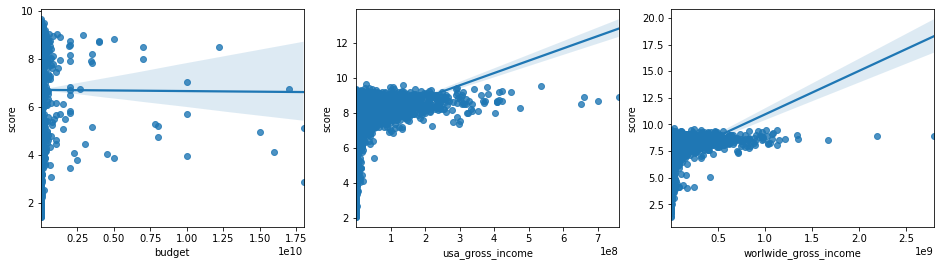

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for idx, x in enumerate(['budget', 'usa_gross_income', 'worlwide_gross_income']):
    sns.regplot(data = money_df[money_df[x] != 0], x=x, y='score', ax=ax[idx])


We see, that correlation of budget with target variable is not that great, whether the incomes features are quite good in this regard. This is no surprise, because actually the information of incomes is information and we cannot use it in our model, due to data leakage. With our model we want to estimate the reception of the film at the moment when it wasn't actually avaluated yet, whil information about incomes comes much later after movie release.

Also, if we look at the budget feature values we will see that they are not in one currency.

In [96]:
full_dataset['budget'].dropna().str.split().apply(lambda x:x[0]).unique()

array(['$', 'ITL', 'ROL', 'SEK', 'FRF', 'NOK', 'GBP', 'DEM', 'PTE', 'CAD',
       'INR', 'CHF', 'FIM', 'JPY', 'DKK', 'NLG', 'PLN', 'RUR', 'AUD',
       'KRW', 'BEF', 'XAU', 'HKD', 'NZD', 'CNY', 'ESP', 'EUR', 'PYG',
       'ISK', 'IEP', 'TRL', 'HRK', 'SIT', 'PHP', 'DOP', 'JMD', 'CZK',
       'SGD', 'BRL', 'BDT', 'ATS', 'BND', 'HUF', 'EGP', 'THB', 'GRD',
       'ZAR', 'NPR', 'IDR', 'PKR', 'EEK', 'MXN', 'BGL', 'YUM', 'MYR',
       'IRR', 'CLP', 'SKK', 'LTL', 'TWD', 'MTL', 'LVL', 'COP', 'ARS',
       'UAH', 'NGN', 'ILS', 'VEB'], dtype=object)

So we cannot simply extract number, but we should use exchange rates. But in this list there some obsolete currencies, and some exchange rates changed significantly with time. So it will be better to leave only two  top currencies USD and EUR and drop all others. We will use some mean excahnge rates between dollar and euro and transform all to dollars.

In [157]:
def budget_impute_converter(X):
    res = pd.DataFrame()
    res['currency'] = X.str.split().apply(lambda x:x[0] if type(x) == list and x[0] in ['$', 'EUR'] else 0)
    res['budget'] = X.str.split().apply(lambda x:int(x[1]) if type(x) == list else 0)
    mapping = {'$': 1, 'EUR': 1.2, 0: 0}
    res['currency'] = res['currency'].map(mapping)
    res['no_budget'] = res['currency'].apply(lambda x: not bool(x)).astype(int)
    res['budget'] = res['currency'] * res['budget']
    res['budget'] = MinMaxScaler().fit_transform(res['budget'].values.reshape(-1, 1))
    res.drop('currency', axis=1, inplace=True)
    return res

In [158]:
budget_transformer = FunctionTransformer(budget_impute_converter)

### Duration

In [51]:
print(f"Missing values: \n{full_dataset['duration'].isna().sum()}")

Missing values: 
0


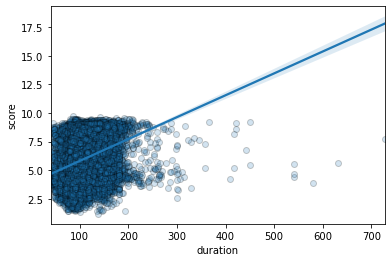

In [52]:
sns.regplot(data = df_plot, x='duration', y='score', scatter_kws={'alpha':0.2, 'edgecolor':'black'});

We can scale and use it.

### Metascore, reviews_from_users, reviews_from_critics

This three features are also information from future and cannot be used except for target variable in our case. We didn't use it the as target variable, because metascore has mostly missing values, and other two doesn't provide anough information to estimate movie reception level. So, we simply drop them.

## Building pipeline

Extracting date features

In [64]:
X_tr['date_published'] = pd.to_datetime(X_tr['date_published'])
X_te['date_published'] = pd.to_datetime(X_te['date_published'])
X_tr['month'] = X_tr['date_published'].dt.month
X_te['month'] = X_te['date_published'].dt.month
X_tr['day_of_week'] = X_tr['date_published'].dt.dayofweek
X_te['day_of_week'] = X_te['date_published'].dt.dayofweek
X_tr.drop('date_published', axis=1, inplace=True)
X_te.drop('date_published', axis=1, inplace=True)
X_tr.head()

,imdb_title_id,title,original_title,year,genre,duration,country,language,director,writer,...,actors,description,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,month,day_of_week
42197,tt0362969,Perros callejeros II,Perros callejeros II,1979,"Action, Drama",100,"Mexico, Spain",Spanish,José Antonio de la Loma,José Antonio de la Loma,...,"Ángel Fernández Franco, Teresa Giménez, Reyes ...",A veteran policeman named Fernando feels a lot...,NaN,NaN,NaN,NaN,5.0,1.0,1,0
44031,tt0404163,Even Money,Even Money,2006,"Crime, Drama",113,"USA, Germany",English,Mark Rydell,Robert Tannen,...,"Kim Basinger, Kelsey Grammer, Michael Eaves, F...",Gambling addiction bring the stories of three ...,NaN,$ 64458,$ 111974,34.0,29.0,48.0,11,2
23257,tt0095426,Kamarád do deste,Kamarád do deste,1988,"Comedy, Crime",72,Czechoslovakia,Czech,Jaroslav Soukup,"Jaroslav Soukup, Miroslav Vaic",...,"Sagvan Tofi, Lukás Vaculík, Beata Andraszewicz...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0
52075,tt1095432,Un poco de chocolate,Un poco de chocolate,2008,Drama,98,Spain,Spanish,Aitzol Aramaio,"Aitzol Aramaio, Unai Elorriaga",...,"Héctor Alterio, Daniel Brühl, Julieta Serrano,...","In a small town in the Basque country, Lucas a...",EUR 2600000,NaN,$ 271475,NaN,NaN,2.0,4,2
21427,tt0089775,Parking,Parking,1985,"Fantasy, Musical",95,France,French,Jacques Demy,Jacques Demy,...,"Francis Huster, Laurent Malet, Keiko Itô, Géra...",This film is an update of Jean Cocteau's Orphe...,NaN,NaN,NaN,NaN,2.0,1.0,5,2


In [362]:
simple_impute_cols = ['director', 'production_company']
groupby_impute_cols = ['country', 'language']
date_cols = ['year', 'month', 'day_of_week']

# we need this because CountVectorizer takes 1D-array as input, but SimpleImputer outputs 2D
one_dim = FunctionTransformer(np.reshape, kw_args={'newshape':-1})



cat_simple_transformer = Pipeline([('encoder',CatBoostEncoder()),
                                   ('scaler', MinMaxScaler())])
cat_groupby_transformer = Pipeline([('imputer', GroupbyImputer(groupby_column='country')),
                                    ('encoder', CatBoostEncoder()),
                                    ('scaler', MinMaxScaler())])
cv_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                           ('flatten', one_dim),
                           ('vectorizer', CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b'))])



preprocess = ColumnTransformer([('simple_impute', cat_simple_transformer, simple_impute_cols),
                                ('groupby_impute', cat_groupby_transformer, groupby_impute_cols),
                                ('date', OneHotEncoder(handle_unknown='ignore'), date_cols),
                                ('cv_country', cv_transformer, ['country']),
                                ('cv_genre', cv_transformer, ['genre']),
                                ('budget', budget_transformer, 'budget'),
                                ('duration', MinMaxScaler(), ['duration'])],
                              remainder='drop', n_jobs=-1)

### Part 3.

Train and compare the models

3.1. Select models, you are going to train, select hyperparameters that have to be tunes.

In [363]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [364]:
sgd_pipe = Pipeline([('preprocess', preprocess),
                     ('estimator', SGDRegressor())])
rf_pipe = Pipeline([('preprocess', preprocess),
                     ('estimator', RandomForestRegressor())])
xgb_pipe = Pipeline([('preprocess', preprocess),
                     ('estimator', GradientBoostingRegressor())])

sgd_params = {'estimator__loss':['squared_loss', 'huber'], 'estimator__alpha': np.logspace(-4, 0, 10)}
rf_params =  {'estimator__n_estimators': range(5, 55, 5), 'estimator__max_depth': range(2, 8)}
xgb_params =  {'estimator__n_estimators': range(5, 55, 5), 'estimator__max_depth': range(2, 8)}

3.2 Use cross-validation to compare models and select best set of hyperparameters

In [365]:
sgd_grid = GridSearchCV(estimator=sgd_pipe, param_grid=sgd_params, scoring='r2', cv=3, n_jobs=-1)
rf_grid = GridSearchCV(estimator=rf_pipe, param_grid=rf_params, scoring='r2', cv=3, n_jobs=-1)
xgb_grid = GridSearchCV(estimator=xgb_pipe, param_grid=xgb_params, scoring='r2', cv=3, n_jobs=-1)

In [368]:
sgd_grid.fit(X_tr, y_tr)
rf_grid.fit(X_tr, y_tr)
xgb_grid.fit(X_tr, y_tr);

In [371]:
print(f'''SGD best: {sgd_grid.best_score_:.2f}
Random Forest best: {rf_grid.best_score_:.2f}
XGBoost best: {xgb_grid.best_score_:.2f}''')

SGD best: 0.37
Random Forest best: 0.38
XGBoost best: 0.42


In [373]:
xgb_grid.best_params_

{'estimator__max_depth': 7, 'estimator__n_estimators': 50}

We see that best params are border values, so we can try to shift param window. Instead of searching accross all grid, we will fix one parameter and swipe across another.

In [378]:
xgb_params2 = {'estimator__n_estimators': range(50, 120, 5), 'estimator__max_depth': [7]}
xgb_grid2 = GridSearchCV(estimator=xgb_pipe, param_grid=xgb_params2, scoring='r2', cv=3, n_jobs=-1)
xgb_grid2.fit(X_tr, y_tr);

In [379]:
xgb_grid2.best_score_, xgb_grid2.best_params_

(0.4301788595226832,
 {'estimator__max_depth': 7, 'estimator__n_estimators': 115})

In [380]:
xgb_params3 = {'estimator__n_estimators': range(115, 150, 5), 'estimator__max_depth': [7]}
xgb_grid3 = GridSearchCV(estimator=xgb_pipe, param_grid=xgb_params3, scoring='r2', cv=3, n_jobs=-1)
xgb_grid3.fit(X_tr, y_tr);

In [381]:
xgb_grid3.best_score_, xgb_grid3.best_params_

(0.43068289578785174,
 {'estimator__max_depth': 7, 'estimator__n_estimators': 135})

Now we can change other param

In [384]:
xgb_params4 = {'estimator__n_estimators': [135], 'estimator__max_depth': range(3, 9)}
xgb_grid4 = GridSearchCV(estimator=xgb_pipe, param_grid=xgb_params4, scoring='r2', cv=3, n_jobs=-1)
xgb_grid4.fit(X_tr, y_tr);

In [385]:
xgb_grid4.best_score_, xgb_grid4.best_params_

(0.43060925376764275,
 {'estimator__max_depth': 7, 'estimator__n_estimators': 135})

3.3 Which model and setup is the best? How does it perform on the test dataset? If you were to present this model to the client, how would you describe it?

Best model is XGBoost with max_depth 7 and n_estimators 135

In [389]:
best_model = xgb_grid4.best_estimator_
best_model.fit(X_tr, y_tr);

In [388]:
r2 = r2_score(y_te, best_model.predict(X_te))
print(f'Best model performance on test data: {r2:.2f}')

Best model performance on test data: 0.46


In [425]:
cols = ['director', 'production_company', 'language']


cv_transformer.fit(X_tr['country'].values.reshape(-1,1))
countries = list(cv_transformer[2].vocabulary_.keys())
cv_transformer.fit(X_tr['genre'].values.reshape(-1,1))
genres = list(cv_transformer[2].vocabulary_.keys())
ohe = OneHotEncoder(handle_unknown='ignore').fit(X_tr['year'].values.reshape(-1, 1))
years = list(ohe.get_feature_names())
ohe = OneHotEncoder(handle_unknown='ignore').fit(X_tr['month'].values.reshape(-1, 1))
months = list(ohe.get_feature_names())
ohe = OneHotEncoder(handle_unknown='ignore').fit(X_tr['day_of_week'].values.reshape(-1, 1))
dows = list(ohe.get_feature_names())

In [426]:
cols = cols + countries + genres + years + months + dows + ['budget', 'no_budget', 'duration']

In [429]:
feats = pd.DataFrame({'Feature_score':best_model[1].feature_importances_}, index=cols)

In [432]:
feats.sort_values(by='Feature_score', ascending=False)

,Feature_score
director,0.368608
budget,0.183917
production_company,0.097061
duration,0.079660
language,0.059383
...,...
thriller,0.000000
x0_1957,0.000000
x0_1956,0.000000
x0_1955,0.000000


This model estimates the overall reception of the new movie, or the movie which wasn't evaluated by users of IMDB yet.
The most important features to consider according to this model are director of the movie, and it's budget. This is quite expecatble result which totally correlates with common sense.

In [441]:
feats.apply(lambda x: np.allclose(x, 0), axis=1).sum()

90

Features with importance close to zero:

In [445]:
list(feats[feats.apply(lambda x: np.allclose(x, 0), axis=1)].index)

['mexico',
 'usa',
 'rica',
 'qatar',
 'moldova',
 'libya',
 'saudi',
 'montenegro',
 'cambodia',
 'honduras',
 'north',
 'namibia',
 'british',
 'virgin',
 'islands',
 'ecuador',
 'côte',
 'd',
 'ivoire',
 'tajikistan',
 'nepal',
 'mozambique',
 'paraguay',
 'zimbabwe',
 'suriname',
 'papua',
 'mauritania',
 'verde',
 'jan',
 'syria',
 'guinea-bissau',
 'action',
 'drama',
 'comedy',
 'sci-fi',
 'mystery',
 'thriller',
 'film-noir',
 'sport',
 'horror',
 'war',
 'x0_1912',
 'x0_1913',
 'x0_1916',
 'x0_1918',
 'x0_1920',
 'x0_1921',
 'x0_1922',
 'x0_1926',
 'x0_1927',
 'x0_1928',
 'x0_1929',
 'x0_1932',
 'x0_1933',
 'x0_1938',
 'x0_1940',
 'x0_1941',
 'x0_1942',
 'x0_1943',
 'x0_1945',
 'x0_1946',
 'x0_1948',
 'x0_1950',
 'x0_1951',
 'x0_1952',
 'x0_1955',
 'x0_1956',
 'x0_1957',
 'x0_1961',
 'x0_1963',
 'x0_1964',
 'x0_1970',
 'x0_1976',
 'x0_1978',
 'x0_1987',
 'x0_1988',
 'x0_1991',
 'x0_1993',
 'x0_1995',
 'x0_1996',
 'x0_2001',
 'x0_2003',
 'x0_2006',
 'x0_2008',
 'x0_2009',
 'x0_

Seems like there is still room for improvement for this model, particularly in feature selection field. The year feature can be possibly omited or engineered in some way.